# Decision Analysis - Project 3

## Installs and Imports

In [1]:
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import os
import warnings
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay, partial_dependence, plot_partial_dependence

c:\Users\barte\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Users\barte\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Users\barte\AppData\Local\Programs\Python\Python311\L

In [3]:
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
set_all_seeds(42)
warnings.filterwarnings("ignore")

## Functions, Models and Utilities

### Utils

In [5]:
def plot_columns(df, figsize = (12, 8), color="grey"):
    num_cols = len(df.columns)
    num_rows = (num_cols + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    for i, column in enumerate(df.columns):
        ax = axes[i // 2, i % 2]
        df[column].plot(kind='hist', ax=ax, title=column, color=color)
        ax.set_title(f"Distribution for {column}")
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    fig.suptitle("Data Distribution Plot")
    plt.tight_layout()
    plt.show()

In [6]:
def plot_stats(accuracy, test_accuracy, f1, f1_test, auc, auc_test):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    color = 'grey'
    axes[0].bar(['Train', 'Test'], [accuracy, test_accuracy], color=color)
    axes[0].axhline(y=0.5, color='red', linestyle='--', label='Random Guess')
    axes[0].set_title('Accuracy')
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    axes[1].bar(['Train', 'Test'], [f1, f1_test], color=color)
    axes[1].set_title('F1 Score')
    axes[1].set_ylim(0, 1)
    axes[2].bar(['Train', 'Test'], [auc, auc_test], color=color)
    axes[2].set_title('AUC')
    axes[2].set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [7]:
def use_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_train)
    accuracy = round(accuracy_score(y_train, y_preds), 4)
    f1 = round(f1_score(y_train, y_preds), 4)
    y_preds_positive = model.predict_proba(X_train)[:, 1]
    auc = round(roc_auc_score(y_train, y_preds_positive), 4)

    y_preds = model.predict(X_test)
    accuracy_test = round(accuracy_score(y_test, y_preds), 4)
    f1_test = round(f1_score(y_test, y_preds), 4)
    y_preds_positive = model.predict_proba(X_test)[:, 1]
    auc_test = round(roc_auc_score(y_test, y_preds_positive), 4)
    return model, accuracy, f1, auc, accuracy_test, f1_test, auc_test

In [8]:
def get_logistic_regression_changed_prediction(test_example, columns, coefficients, intercept, classifier):
    sum= 0.0
    epsilon = 1e-3
    example_list = list(test_example)
    zipped_lists = zip(coefficients, example_list, range(len(coefficients)))
    sorted_lists = sorted(zipped_lists, reverse=True)
    sorted_coeffs, example_list, original_order = zip(*sorted_lists)
    example_list = list(example_list)
    original_order = list(original_order)
    sorted_coeffs = list(sorted_coeffs)

    for i in range(len(example_list)):
        sum += example_list[i]*sorted_coeffs[i]
    sum += intercept
    prev_examples = example_list.copy()
    if sum>=0:
        for i in range(len(example_list)):
            val = -1*intercept-epsilon
            for j in range(len(example_list)):
                if i != j:
                    val -= example_list[j]*sorted_coeffs[j]
            example_list[i] = val/sorted_coeffs[i]
            if example_list[i]<0:
                example_list[i] = 0
            elif example_list[i]>1:
                example_list[i] = 1
            else:
                break
    else:
        for i in range(len(example_list)):
            val = -1*intercept+epsilon
            for j in range(len(example_list)):
                if i != j:
                    val -= example_list[j]*sorted_coeffs[j]
            example_list[i] = val/sorted_coeffs[i]
            if example_list[i]<0:
                example_list[i] = 0
            elif example_list[i]>1:
                example_list[i] = 1
            else:
                break

    original_order = [original_order.index(i) for i in range(len(original_order))]
    example_list = [example_list[i] for i in original_order]
    prev_examples = [prev_examples[i] for i in original_order]
    rounded_examples = [round(example, 4) for example in example_list]
    rounded_prevs = [round(example, 4) for example in prev_examples]
    differences = list(np.array(prev_examples) - np.array(example_list))
    differences = [round(diff, 4) for diff in differences]
    print(f"Columns in order: {columns}")
    print(f"Original Example: {rounded_prevs}")
    print(f"New Example Assigned to a different class: {rounded_examples}")
    print(f"Minimal Differences: {differences}")
    print(f"Model's original decision {classifier.predict([prev_examples])}")
    print(f"Model's new decision: {classifier.predict([example_list])}")

In [9]:
def change_class_by_sampling(test_example, columns, coefficients, intercept, classifier):
    epsilon = 1e-3
    example_list = list(test_example)
    prev_examples = example_list.copy()
    original_class = classifier.predict([example_list])[0]
    i=0
    while True:
        zipped_lists = zip(coefficients, example_list, range(len(coefficients)))
        sorted_lists = sorted(zipped_lists, reverse=True)
        sorted_coeffs, example_list, original_order = zip(*sorted_lists)
        example_list = list(example_list)
        original_order = list(original_order)
        sorted_coeffs = list(sorted_coeffs)
        if original_class == 1:
            example_list[i] -= epsilon
        else:
            example_list[i] += epsilon
        if example_list[i]<=0:
            example_list[i] = 0
            i+=1
        elif example_list[i]>=1:
            example_list[i] = 1
            i+=1
        original_order = [original_order.index(i) for i in range(len(original_order))]
        example_list = [example_list[i] for i in original_order]
        new_class = classifier.predict([example_list])[0]
        if new_class != original_class:
            break

    rounded_examples = [round(example, 4) for example in example_list]
    rounded_prevs = [round(example, 4) for example in prev_examples]
    differences = list(np.array(prev_examples) - np.array(example_list))
    differences = [round(diff, 4) for diff in differences]
    print(f"Columns in order: {columns}")
    print(f"Original Example: {rounded_prevs}")
    print(f"New Example Assigned to a different class: {rounded_examples}")
    print(f"Minimal Differences: {differences}")
    print(f"Model's original decision {original_class}")
    print(f"Model's new decision: {new_class}")

### Neural MCDA

In [10]:
def morbius_transform(input_row):
    result = list(input_row)
    for i in range(len(input_row)):
        for j in range(i+1, len(input_row)):
            result.append(min(input_row[i], input_row[j]))

    return np.array(result)

In [11]:
class CriteriaLayer(nn.Linear):
    def __init__(self, num_in_features:int, include_bias:bool=False, min_weight:float=1e-8):
        super().__init__(num_in_features, 1, include_bias)
        self.is_bias = include_bias
        self.min_w = min_weight
        if include_bias:
            nn.init.uniform_(self.bias, self.min_w ,1.0)
        else:
            self.bias = None

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.1, 1.0)

    def ensure_proper_weights(self):
        with torch.no_grad():
            self.weight.data[self.weight.data<0]=self.min_w
        weights = self.weight
        return weights

    def forward(self, input:torch.Tensor)->torch.Tensor:
        weights = self.ensure_proper_weights()
        return F.linear(input, weights, self.bias)

In [12]:
class InteractionLayer(nn.Linear):
    def __init__(self, num_in_features:int, criterion_layer:CriteriaLayer):
        num_interactions = ((num_in_features-1)*num_in_features)//2
        super().__init__(num_interactions, 1, False)
        self.in_features = num_in_features
        self.criterion_layer = criterion_layer
        self.num_interactions = num_interactions

    def reset_parameters(self):
        nn.init.normal_(self.weight, 0.0, 0.1)

    def ensure_proper_weights(self):
        with torch.no_grad():
            w_i=0
            w = self.criterion_layer.ensure_proper_weights()
            for i in range(self.in_features):
                for j in range(i+1,self.in_features):
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,i])
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,j])
                    w_i+=1
        weights = self.weight
        return weights

    def forward(self, input:torch.Tensor)->torch.Tensor:
        weights = self.ensure_proper_weights()
        return F.linear(input, weights, None)

In [13]:
class ThresholdLayer(nn.Module):
    def __init__(self, threshold: float = None, requires_grad: bool = True):
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(torch.FloatTensor(1).uniform_(0.1, 0.9), requires_grad=requires_grad)
        else:
            self.threshold = nn.Parameter(torch.FloatTensor([threshold]), requires_grad=requires_grad)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return x - self.threshold

In [14]:
class ChoquetIntegralConstrained(nn.Module):
    def __init__(self, num_criteria:int, mobius_transform):
        super().__init__()
        self.num_criteria = num_criteria
        self.criteria_layer = CriteriaLayer(num_criteria)
        self.interaction_layer = InteractionLayer(num_criteria, self.criteria_layer)
        self.threshold_layer = ThresholdLayer()
        self.transform = mobius_transform

    def preprocess(self, input: np.array)->np.array:
        processed = []
        for row in input:
            processed.append(self.transform(row))
        return np.array(processed)

    def forward(self, input:torch.Tensor)->torch.Tensor:
        if len(input.shape)==3:
            input = input[:,0,:]

        x_wi = self.criteria_layer(input[:,:self.num_criteria])
        x_wij = self.interaction_layer(input[:,self.num_criteria:])
        weight_sum = self.criteria_layer.ensure_proper_weights().sum()+self.interaction_layer.ensure_proper_weights().sum()
        score =  (x_wi+x_wij)/(weight_sum)
        output = self.threshold_layer(score)
        return output.squeeze()

In [15]:
def Regret(output: torch.FloatTensor, target: torch.LongTensor) -> torch.FloatTensor:
    return torch.mean(F.relu(-(target >= 1).float() * output) + F.relu((target < 1).float() * output))

### ANN

In [16]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x.squeeze()

class CompatibleTorchModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model, optimizer, criterion, num_epochs, custom_acc_threshold = False):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.custom_acc_threshold = custom_acc_threshold

    def fit(self, X_train, y_train):
        print("Fitting Neural Network Model")
        self.model.train()
        train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        history = {'epoch': [], 'accuracy': [], 'loss': []}
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            correct = 0
            total = 0
            for inputs, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)
                predicted = outputs.detach().numpy()
                if self.custom_acc_threshold:
                    predicted[predicted>=0.0] = 1
                    predicted[predicted<0.0] = 0
                else:
                    predicted[predicted>=0.5] = 1
                    predicted[predicted<0.5] = 0
                total += len(targets)
                expected = targets.numpy()
                correct += np.sum(predicted == expected)
            epoch_loss /= len(train_loader.dataset)
            epoch_accuracy = correct / total
            print(f"Training Results - Epoch: {epoch+1}  Avg accuracy: {round(epoch_accuracy, 4)} Avg loss: {round(epoch_loss, 4)}")
            history['epoch'].append(epoch)
            history['accuracy'].append(epoch_accuracy)
            history['loss'].append(epoch_loss)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['epoch'], history['loss'], label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history['epoch'], history['accuracy'], label='Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def predict(self, X):
        self.model.eval()
        predictions = []
        for temp_X in X:
            X_input = torch.tensor(temp_X).float()
            with torch.no_grad():
                output = self.model(X_input.unsqueeze(0))
            if self.custom_acc_threshold:
                output = 1 if output > 0.0 else 0
            else:
                output = 1 if output > 0.5 else 0
            predictions.append(output)
        return np.array(predictions)

    def predict_proba(self, X):
        self.model.eval()
        predictions = []
        for temp_X in X:
            X_input = torch.tensor(temp_X).float()
            with torch.no_grad():
                output = self.model(X_input.unsqueeze(0))
                output = np.round(output.item(), 4)
                if self.custom_acc_threshold:
                    output += 0.5
                if output>1:
                    output = 1
            predictions.append([1-output, output])
        return np.array(predictions)

## Data

1. BI-RADS assessment: 1 to 5 (ordinal, non-predictive!)  

2. Age: patient's age in years (integer)

3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

6. Severity: benign=0 or malignant=1 (binominal, goal field!)

In [17]:
# data = pd.read_csv("/content/mammographic.csv")
data = pd.read_csv("mammographic.csv")
data = (data - data.min()) / (data.max() - data.min())
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data

,BI-RADS,Age,Shape,Margin,Density,Severity
0,0.072727,0.525641,0.000000,0.00,0.666667,0.0
1,0.072727,0.333333,0.333333,0.00,0.666667,0.0
2,0.090909,0.474359,1.000000,1.00,0.666667,0.0
3,0.072727,0.076923,0.333333,0.00,0.666667,0.0
4,0.072727,0.358974,0.000000,0.00,0.666667,0.0
...,...,...,...,...,...,...
825,0.072727,0.615385,0.000000,0.00,0.666667,0.0
826,0.072727,0.038462,0.333333,0.00,0.666667,0.0
827,0.090909,0.833333,1.000000,0.75,0.666667,1.0
828,0.090909,0.628205,1.000000,1.00,0.666667,1.0


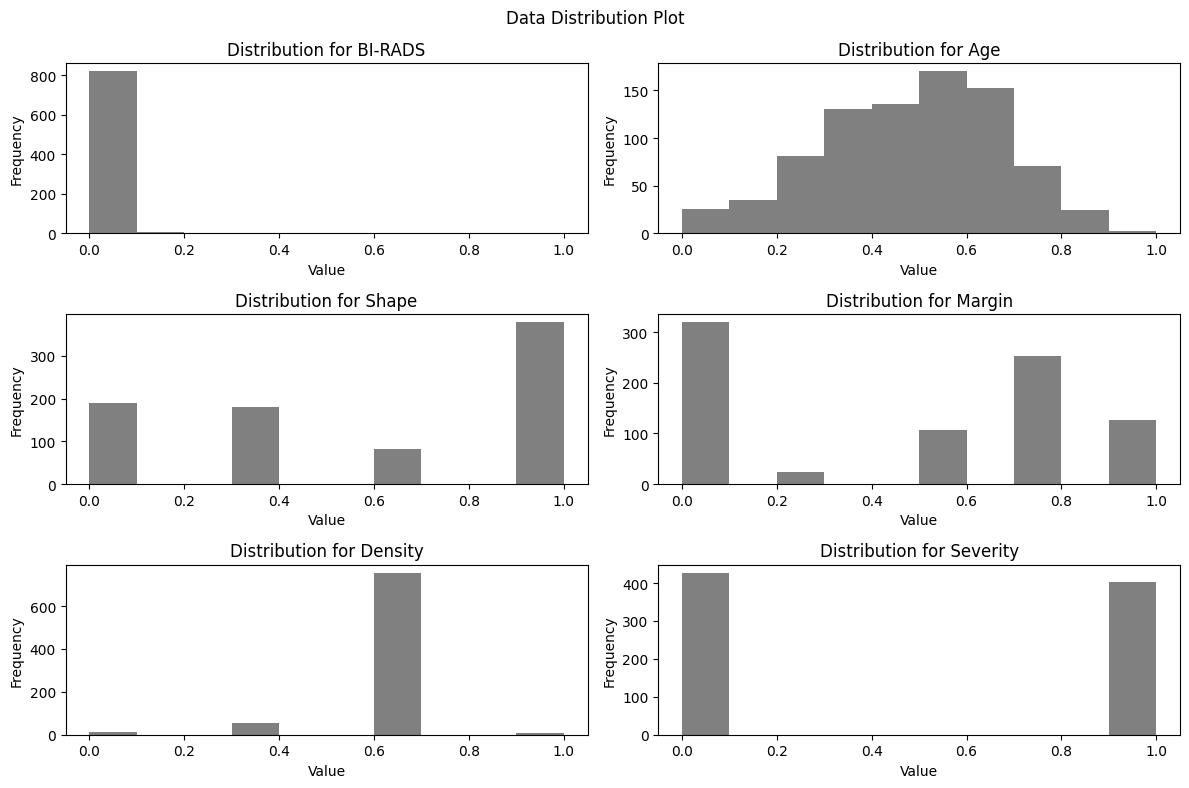

In [18]:
plot_columns(data)

In [19]:
X = data.drop(columns = ["Severity"])
y = data["Severity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Simple Explainable Model - Logistic Regression

### Training

In [20]:
simple_model = LogisticRegression()
simple_model, accuracy, f1, auc, accuracy_test, f1_test, auc_test = use_model(simple_model, X_train, y_train, X_test, y_test)

In [21]:
print(f"Train set accuracy: {accuracy}")
print(f"Train set F1: {f1}")
print(f"Train set AUC: {auc}")
print(f"Test set accuracy: {accuracy_test}")
print(f"Test set F1: {f1_test}")
print(f"Test set AUC: {auc_test}")

Train set accuracy: 0.8163
Train set F1: 0.8174
Train set AUC: 0.8773
Test set accuracy: 0.7711
Test set F1: 0.7912
Test set AUC: 0.8444


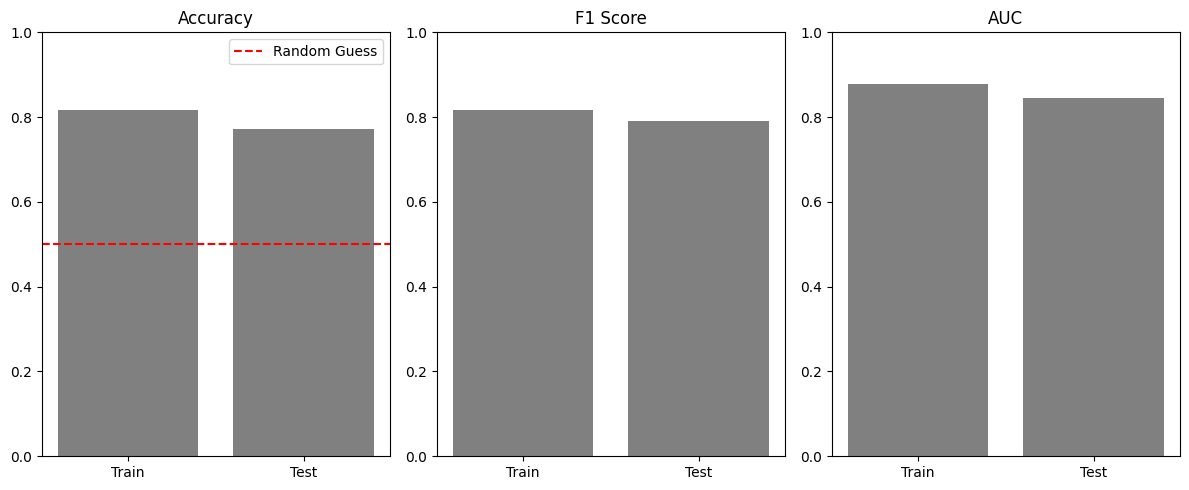

In [22]:
plot_stats(accuracy, accuracy_test, f1, f1_test, auc, auc_test)

### 2.1. Explanation of the decisions

In [23]:
feature_names = X_train.columns
coefficients = simple_model.coef_
intercept = simple_model.intercept_

print(f"Coefficients: {coefficients}")
print(f"intercept: {intercept}")

Coefficients: [[1.16315803 3.33063052 1.8128958  1.68386309 0.39304664]]
intercept: [-3.91537883]


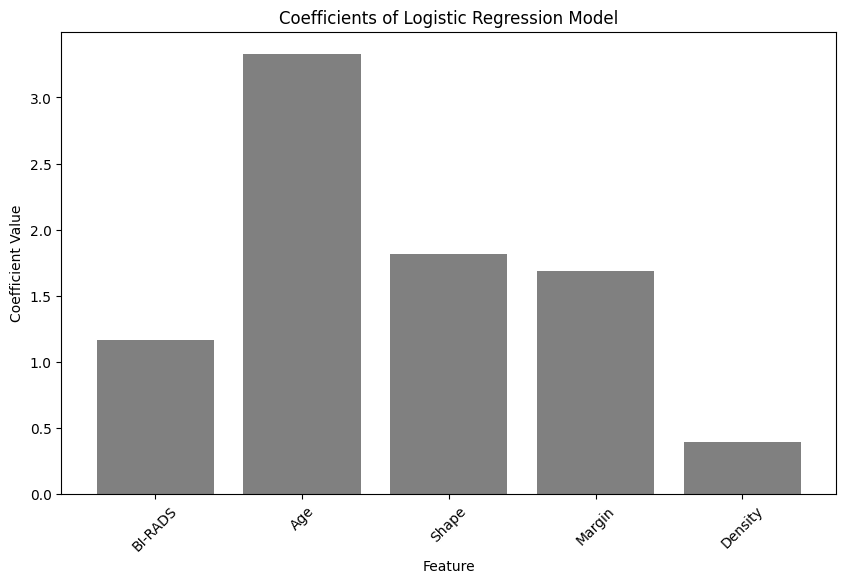

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), coefficients[0], color="grey")
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of Logistic Regression Model')
plt.show()

In [25]:
X_test

,BI-RADS,Age,Shape,Margin,Density
162,0.090909,0.730769,1.000000,0.75,0.666667
305,0.072727,0.666667,1.000000,0.25,0.333333
24,0.090909,0.538462,1.000000,0.50,0.666667
667,0.072727,0.294872,0.333333,0.25,0.666667
574,0.072727,0.705128,1.000000,0.50,0.666667
...,...,...,...,...,...
695,0.090909,0.743590,0.000000,0.75,0.666667
379,0.072727,0.589744,0.333333,0.75,0.666667
208,0.072727,0.294872,0.000000,0.00,0.666667
388,0.072727,0.435897,1.000000,0.75,0.666667


In [26]:
test_example_1 = X_test.iloc[0]
test_label_1 = simple_model.predict(X_test.iloc[0].values.reshape(1, -1))[0]
test_example_2 = X_test.iloc[1]
test_label_2 = simple_model.predict(X_test.iloc[1].values.reshape(1, -1))[0]
test_example_3 = X_test.iloc[9] #taking the 9th example, since we wanted variety with classes
test_label_3 = simple_model.predict(X_test.iloc[9].values.reshape(1, -1))[0]
print(f"Test example:\n{test_example_1}")
print(f"\nAssigned Label: {test_label_1}")
print("________________________________")
print(f"Test example:\n{test_example_2}")
print(f"\nAssigned Label: {test_label_2}")
print("________________________________")
print(f"Test example:\n{test_example_3}")
print(f"\nAssigned Label: {test_label_3}")

Test example:
BI-RADS    0.090909
Age        0.730769
Shape      1.000000
Margin     0.750000
Density    0.666667
Name: 162, dtype: float64

Assigned Label: 1.0
________________________________
Test example:
BI-RADS    0.072727
Age        0.666667
Shape      1.000000
Margin     0.250000
Density    0.333333
Name: 305, dtype: float64

Assigned Label: 1.0
________________________________
Test example:
BI-RADS    0.072727
Age        0.282051
Shape      0.333333
Margin     0.000000
Density    0.666667
Name: 462, dtype: float64

Assigned Label: 0.0


#### Changes from Theoretical Calculations



In [27]:
get_logistic_regression_changed_prediction(test_example_1, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0909, 0.7308, 1.0, 0.75, 0.6667]
New Example Assigned to a different class: [0.0909, 0.1414, 1.0, 0.75, 0.6667]
Minimal Differences: [0.0, 0.5894, 0.0, 0.0, 0.0]
Model's original decision [1.]
Model's new decision: [0.]


In [28]:
get_logistic_regression_changed_prediction(test_example_2, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0727, 0.6667, 1.0, 0.25, 0.3333]
New Example Assigned to a different class: [0.0727, 0.4398, 1.0, 0.25, 0.3333]
Minimal Differences: [0.0, 0.2268, 0.0, 0.0, 0.0]
Model's original decision [1.]
Model's new decision: [0.]


In [29]:
get_logistic_regression_changed_prediction(test_example_3, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0727, 0.2821, 0.3333, 0.0, 0.6667]
New Example Assigned to a different class: [0.0727, 0.8904, 0.3333, 0.0, 0.6667]
Minimal Differences: [0.0, -0.6083, 0.0, 0.0, 0.0]
Model's original decision [0.]
Model's new decision: [1.]


#### Changes from Sampling

In [30]:
change_class_by_sampling(test_example_1, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0909, 0.7308, 1.0, 0.75, 0.6667]
New Example Assigned to a different class: [0.0909, 0.1408, 1.0, 0.75, 0.6667]
Minimal Differences: [0.0, 0.59, 0.0, 0.0, 0.0]
Model's original decision 1.0
Model's new decision: 0.0


In [31]:
change_class_by_sampling(test_example_2, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0727, 0.6667, 1.0, 0.25, 0.3333]
New Example Assigned to a different class: [0.0727, 0.4397, 1.0, 0.25, 0.3333]
Minimal Differences: [0.0, 0.227, 0.0, 0.0, 0.0]
Model's original decision 1.0
Model's new decision: 0.0


In [32]:
change_class_by_sampling(test_example_3, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0727, 0.2821, 0.3333, 0.0, 0.6667]
New Example Assigned to a different class: [0.0727, 0.8911, 0.3333, 0.0, 0.6667]
Minimal Differences: [0.0, -0.609, 0.0, 0.0, 0.0]
Model's original decision 0.0
Model's new decision: 1.0


### SHAP explanation

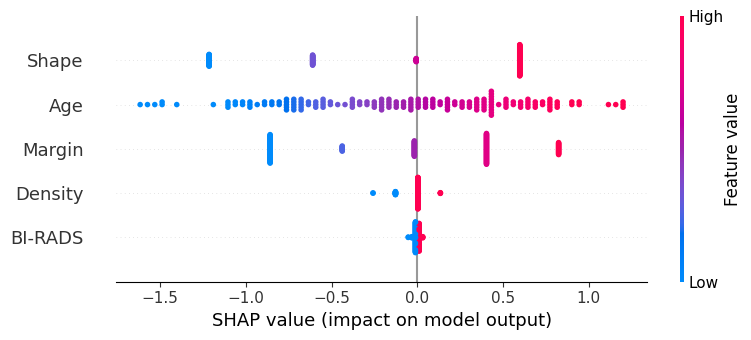

In [33]:
explainer = shap.Explainer(simple_model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

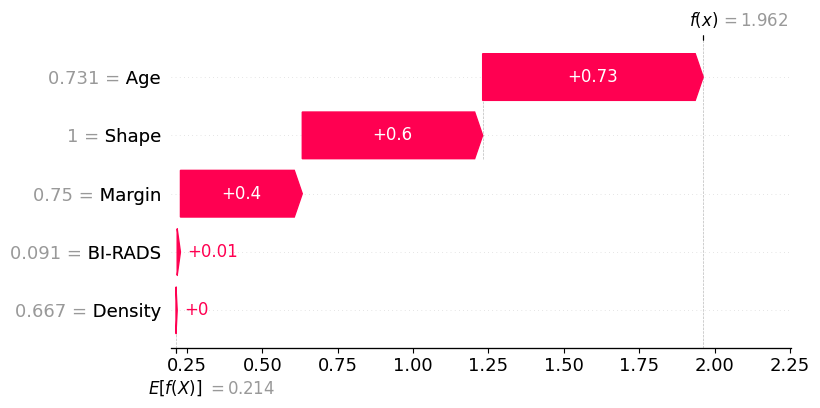

In [34]:
shap.plots.waterfall(shap_values[0])

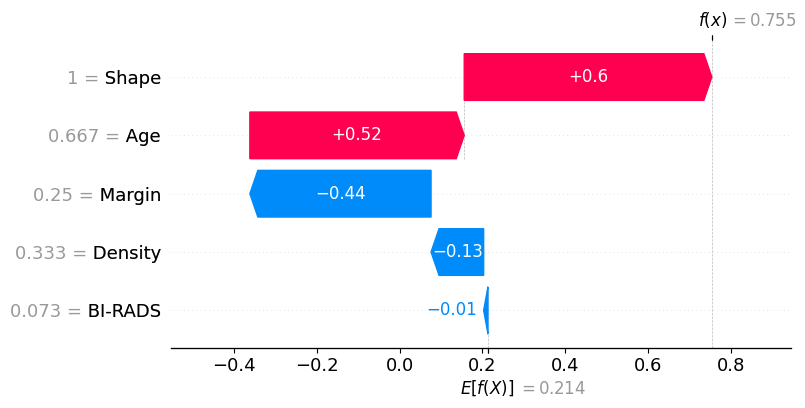

In [35]:
shap.plots.waterfall(shap_values[1])

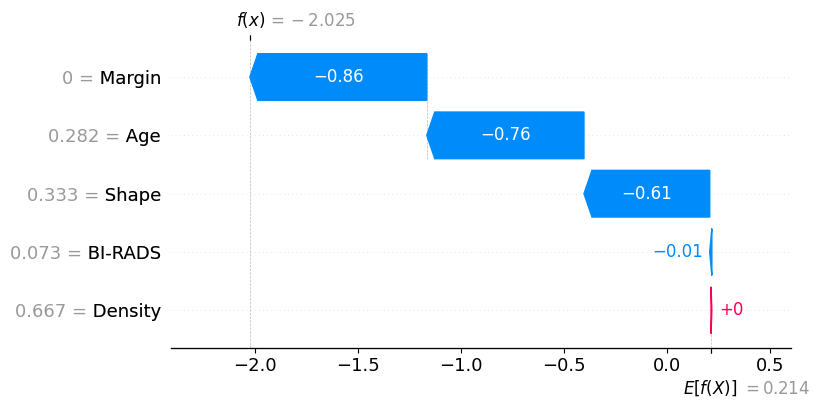

In [36]:
shap.plots.waterfall(shap_values[9])

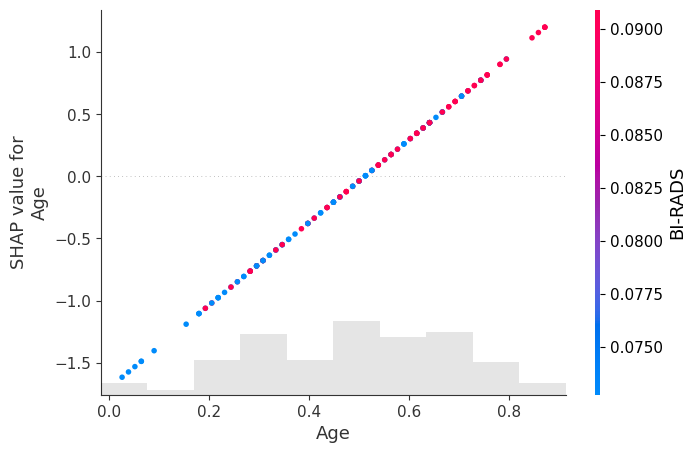

In [37]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

### Pearson correlation as criteria dependence measure

In [38]:
X.corr(method="pearson")

,BI-RADS,Age,Shape,Margin,Density
BI-RADS,1.000000,0.094623,0.180120,0.157771,0.028356
Age,0.094623,1.000000,0.380096,0.420913,0.052417
Shape,0.180120,0.380096,1.000000,0.738014,0.073969
Margin,0.157771,0.420913,0.738014,1.000000,0.124860
Density,0.028356,0.052417,0.073969,0.124860,1.000000


In [83]:
simple_model.predict(X_test.iloc[0:4])

array([1., 1., 1., 0.])

In [84]:
simple_model.predict_proba(X_test.iloc[0:4])

array([[0.12323895, 0.87676105],
       [0.31983897, 0.68016103],
       [0.28891947, 0.71108053],
       [0.82655144, 0.17344856]])

### Partial Dependence Plot

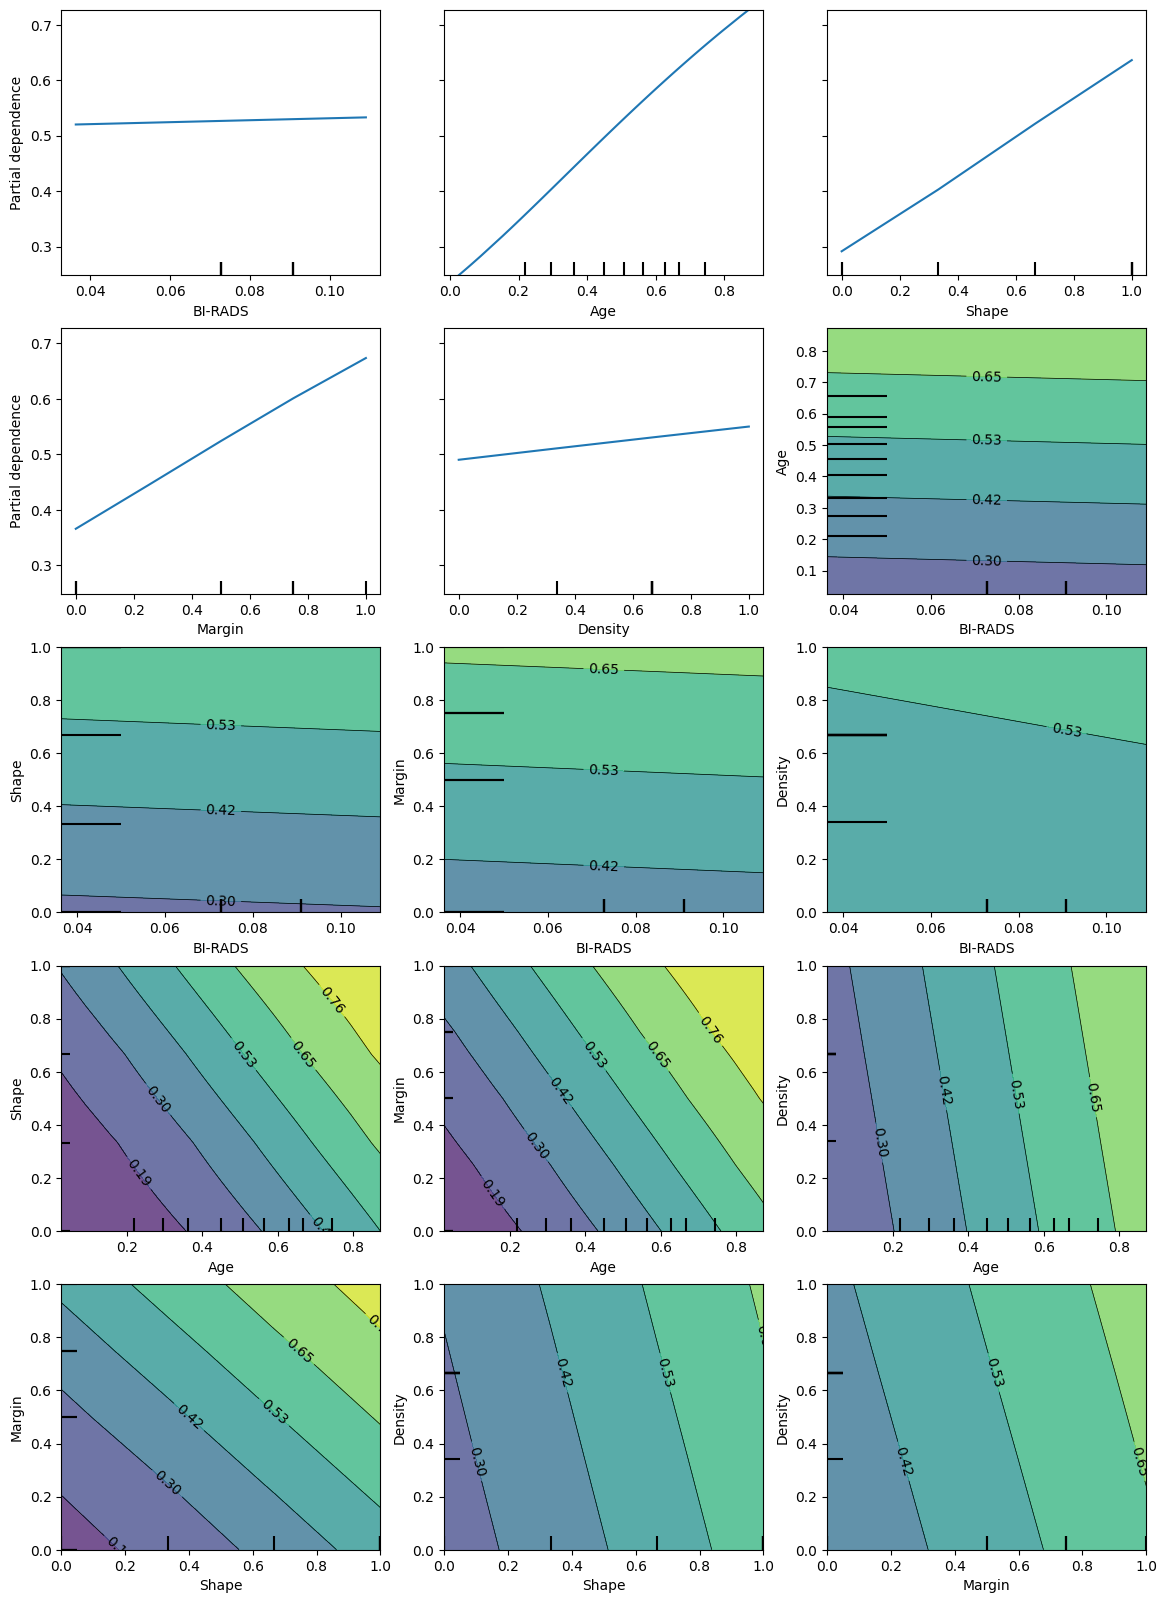

In [85]:
fig, ax = plt.subplots(figsize=(14, 20))
PartialDependenceDisplay.from_estimator(simple_model, X_test, features = [0, 1, 2, 3, 4] + [(a,b) for a in range(5) for b in range(a+1, 5)],
                                         ax=ax, response_method="predict_proba")

#### Conclusions

According to the above calculations, the most influential feature when it comes to making the decision is the age of the patient. The higher the age of the patient, the higher the chance of the example being classified as severe. In addition, all considered values when high, increase likely hood of positive (severe) classification. Additionally, as has been seen in the above tests, we can change the classification of the diagnosis only by manipulating the age (in this case the theoretical and the practical results seem to allign, barring some small differences probably caused by rounding or values of respective epsilons in the functions). When it comes to concrete examples, we have managed to change the classification result for the first tested patient, by simply changing their age. However, it is important to note that the difference is significant in practice the tested person would be decades older due to such a change in the numerical value, however, the result shows the importance of age when deciding the class assignment.

Lastly, when looking at the results from both SHAP's summary plot and the achieved weight coefficents, we can see that shape and margin can also strongly influence the classification result of our model.

### 2.2. Interpretation of the model

• Based on the parameters obtained, can we say something about the user’s preferences? <br>

According to the model's coefficients, the user prefers high scores of alternatives on all criteria in order to make the positive (malignant) classification. The user should pay high attention to the Age criteria in particular as it the most influential in the decision.

• What was the influence of the criteria? Are there any criteria that have no effect, or have a decisive influence? <br>

Based on the model's coefficients we can infer that the Age criteria has more influence than Shape, Margin and Bi-RADS which have a notably higher influence than the Density criteria.

• Are there any dependencies between the criteria? <br>

There is a positive Pearson correlation between every pair of criteria however most of them are weak (0; 0.3] or moderate (0.3; 0.5] with the exception of Shape and Margin with a strong correlation of 0.74 indicating a possible degree of linear dependency between them.

• What is the nature of the criterion, gain, cost, non-monotonic? <br>

Based on the model's coefficients we can infer that the criteria are of gain type i.e. the increase of a criteria increases the possibility of assignment to the positive (severe) class.

• Whether there are any preference thresholds? Are there any evaluations on criteria that are indifferent in terms of preferences? <br>

TODO idk może na podstawie sampling/theoretical change to get a different alternative class assignment

• Interpret the model by at least one (Global Surrogate, Partial Dependence Plot, Permutation Feature Importance ...) <br>

According to the Partial Dependence Plot, every criteria increases the probability of assignment of a positive class (severe) with the increase of values with the steepest slope for the Age criteria. Both Shape and Margin seem to have a significant influence in the decision making process unlike Density and Bi-RADS which are providing only a slight difference on their own. Similar conclusions can be derived by looking at the joint Partial Dependence Plots with two criteria determining the value of Partial Dependence.


TODO: Nie mam pojecia o co mu chodzi tutaj, what do you mean preference thresholds, to jest dataset do klasyfikacji raka

## Interpretable Neural MCDA - ANN-Ch-Constr.

In [38]:
lr = 1e-3
weight_decay = 1e-4
criterion = Regret
num_epochs = 100

Fitting Neural Network Model
Training Results - Epoch: 1  Avg accuracy: 0.7922 Avg loss: 0.0265
Training Results - Epoch: 2  Avg accuracy: 0.7922 Avg loss: 0.0224
Training Results - Epoch: 3  Avg accuracy: 0.7997 Avg loss: 0.0188
Training Results - Epoch: 4  Avg accuracy: 0.8012 Avg loss: 0.0158
Training Results - Epoch: 5  Avg accuracy: 0.7997 Avg loss: 0.0141
Training Results - Epoch: 6  Avg accuracy: 0.8012 Avg loss: 0.0131
Training Results - Epoch: 7  Avg accuracy: 0.8027 Avg loss: 0.0123
Training Results - Epoch: 8  Avg accuracy: 0.8012 Avg loss: 0.0116
Training Results - Epoch: 9  Avg accuracy: 0.8012 Avg loss: 0.0109
Training Results - Epoch: 10  Avg accuracy: 0.8027 Avg loss: 0.0102
Training Results - Epoch: 11  Avg accuracy: 0.8012 Avg loss: 0.0095
Training Results - Epoch: 12  Avg accuracy: 0.8042 Avg loss: 0.0088
Training Results - Epoch: 13  Avg accuracy: 0.8027 Avg loss: 0.0083
Training Results - Epoch: 14  Avg accuracy: 0.8027 Avg loss: 0.0079
Training Results - Epoch: 15

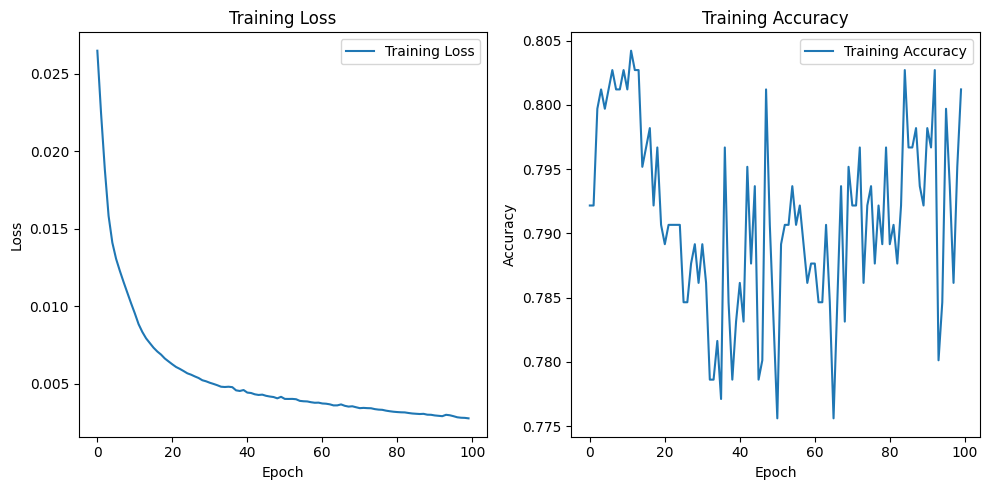

In [39]:
num_criteria = len(X_train.columns)
neural_MCDA_model = ChoquetIntegralConstrained(num_criteria = num_criteria, mobius_transform = morbius_transform)
X_train_processed = neural_MCDA_model.preprocess(X_train.values)
X_test_processed = neural_MCDA_model.preprocess(X_test.values)
optimizer = optim.AdamW(neural_MCDA_model.parameters(), lr=lr, weight_decay=weight_decay)
neural_MCDA_compatible = CompatibleTorchModel(neural_MCDA_model, optimizer, criterion, num_epochs, custom_acc_threshold=True)
neural_MCDA_compatible, accuracy, f1, auc, accuracy_test, f1_test, auc_test = use_model(neural_MCDA_compatible, X_train_processed, y_train.values, X_test_processed, y_test.values)
neural_MCDA_model = neural_MCDA_compatible.model

In [40]:
print(f"Train set accuracy: {accuracy}")
print(f"Train set F1: {f1}")
print(f"Train set AUC: {auc}")
print(f"Test set accuracy: {accuracy_test}")
print(f"Test set F1: {f1_test}")
print(f"Test set AUC: {auc_test}")

Train set accuracy: 0.7967
Train set F1: 0.7833
Train set AUC: 0.8695
Test set accuracy: 0.8072
Test set F1: 0.8118
Test set AUC: 0.8365


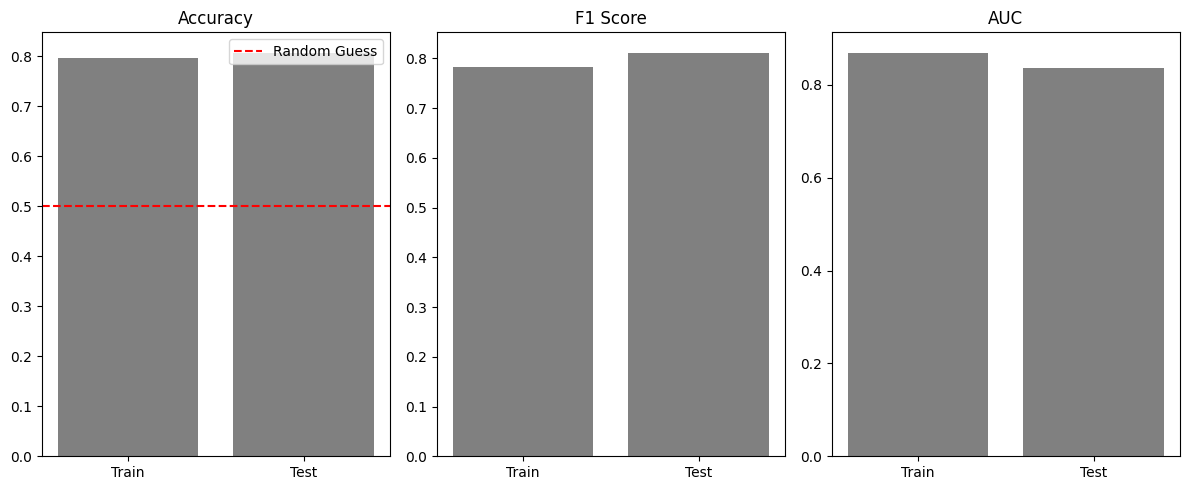

In [41]:
plot_stats(accuracy, accuracy_test, f1, f1_test, auc, auc_test)

### 2.1. Explanation of the decisions

#### Changes from Theoretical Calculations

TODO: write

#### Changes from Sampling

TODO: write

### SHAP explanation

In [42]:
column_names = list(X_test.columns)
new_cols = []
for i in range(len(column_names)):
    for ii in range(i+1, len(column_names)):
        new_cols.append(column_names[i] + "_" + column_names[ii])
column_names += new_cols
explainer = shap.KernelExplainer(neural_MCDA_compatible.predict, X_test_processed)
shap_values = explainer(X_test_processed)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

Using 166 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


AttributeError: 'Kernel' object has no attribute 'masker'

In [45]:
new_cols

['BI-RADS_Age',
 'BI-RADS_Shape',
 'BI-RADS_Margin',
 'BI-RADS_Density',
 'Age_Shape',
 'Age_Margin',
 'Age_Density',
 'Shape_Margin',
 'Shape_Density',
 'Margin_Density']

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.waterfall(shap_values[1])

In [ ]:
shap.plots.waterfall(shap_values[9])

In [ ]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

#### Conclusions

TODO: write

### 2.2. Interpretation of the model

• Based on the parameters obtained, can we say something about the user’s preferences? <br>
• What was the influence of the criteria? Are there any criteria that have no effect, or have a decisive influence? <br>
• Are there any dependencies between the criteria? <br>
• What is the nature of the criterion, gain, cost, non-monotonic? <br>
• Whether there are any preference thresholds? Are there any evaluations on criteria that are indifferent in terms of preferences? <br>
• Interpret the model by at least one (Global Surrogate, Partial Dependence Plot, Permutation Feature Importance ...) <br>

TODO: write

### ANN Model

In [ ]:
lr = 1e-3
weight_decay = 1e-4
criterion = nn.BCELoss()
num_epochs = 100

Fitting Neural Network Model
Training Results - Epoch: 1  Avg accuracy: 0.4849 Avg loss: 0.6827
Training Results - Epoch: 2  Avg accuracy: 0.6672 Avg loss: 0.6441
Training Results - Epoch: 3  Avg accuracy: 0.7892 Avg loss: 0.5779
Training Results - Epoch: 4  Avg accuracy: 0.8012 Avg loss: 0.5115
Training Results - Epoch: 5  Avg accuracy: 0.8012 Avg loss: 0.4852
Training Results - Epoch: 6  Avg accuracy: 0.7937 Avg loss: 0.4744
Training Results - Epoch: 7  Avg accuracy: 0.7997 Avg loss: 0.475
Training Results - Epoch: 8  Avg accuracy: 0.8042 Avg loss: 0.4631
Training Results - Epoch: 9  Avg accuracy: 0.8087 Avg loss: 0.4549
Training Results - Epoch: 10  Avg accuracy: 0.8102 Avg loss: 0.4536
Training Results - Epoch: 11  Avg accuracy: 0.8087 Avg loss: 0.4464
Training Results - Epoch: 12  Avg accuracy: 0.7997 Avg loss: 0.4508
Training Results - Epoch: 13  Avg accuracy: 0.8133 Avg loss: 0.4512
Training Results - Epoch: 14  Avg accuracy: 0.8117 Avg loss: 0.4419
Training Results - Epoch: 15 

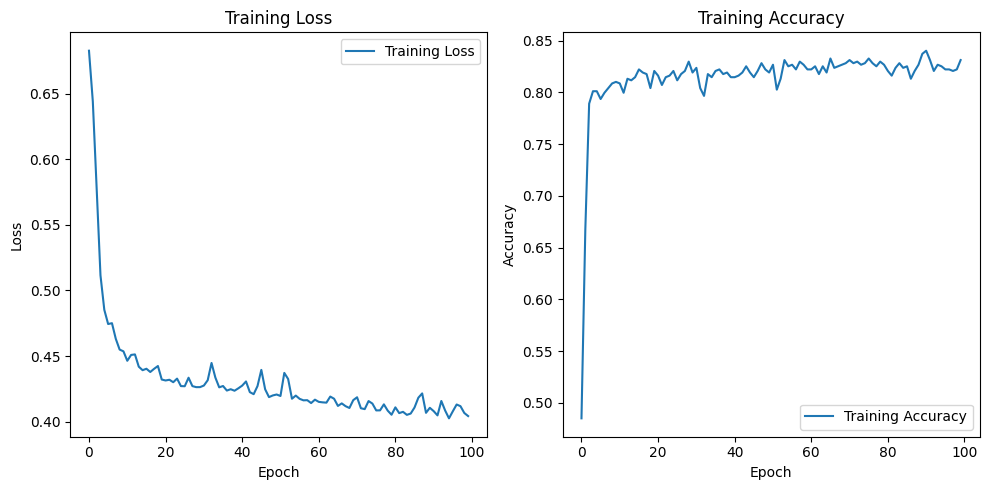

In [ ]:
ann_model = ANN(len(X_train.columns), 1)
optimizer = optim.AdamW(ann_model.parameters(), lr=lr, weight_decay=weight_decay)
torch_model = CompatibleTorchModel(ann_model, optimizer, criterion, num_epochs)
torch_model, accuracy, f1, auc, accuracy_test, f1_test, auc_test = use_model(torch_model, X_train.values, y_train.values, X_test.values, y_test.values)
ann_model = torch_model.model

In [ ]:
print(f"Train set accuracy: {accuracy}")
print(f"Train set F1: {f1}")
print(f"Train set AUC: {auc}")
print(f"Test set accuracy: {accuracy_test}")
print(f"Test set F1: {f1_test}")
print(f"Test set AUC: {auc_test}")

Train set accuracy: 0.8313
Train set F1: 0.8255
Train set AUC: 0.901
Test set accuracy: 0.8012
Test set F1: 0.8156
Test set AUC: 0.8629


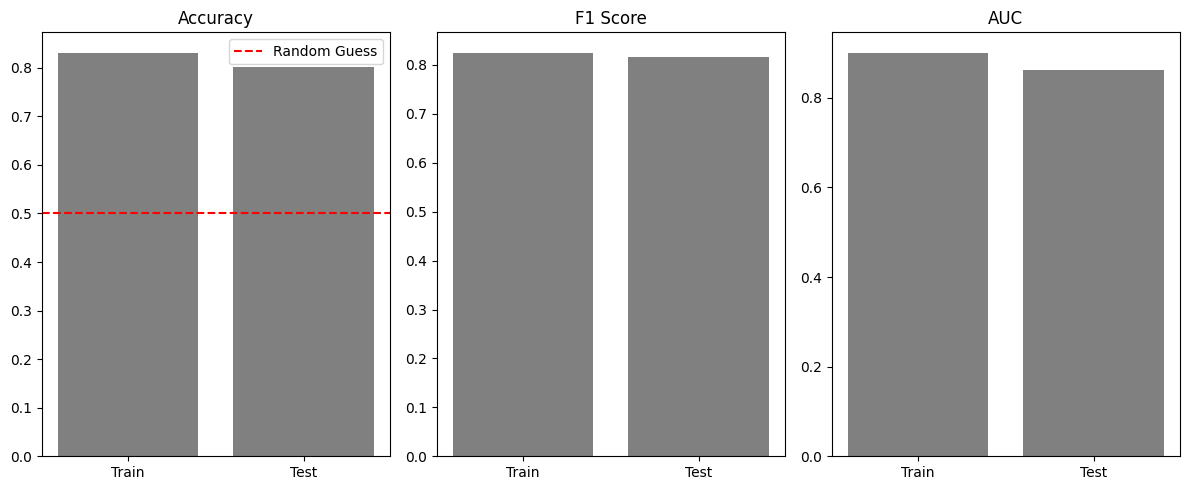

In [ ]:
plot_stats(accuracy, accuracy_test, f1, f1_test, auc, auc_test)

### 2.1. Explanation of the decisions

#### Changes from Theoretical Calculations

TODO: write

#### Changes from Sampling


TODO: write

### SHAP explanation

  0%|          | 0/166 [00:00<?, ?it/s]

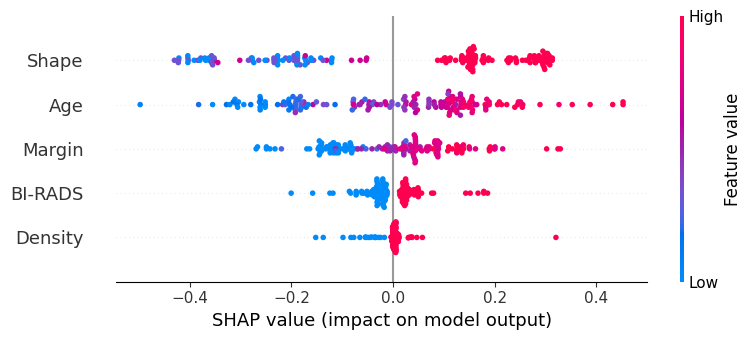

In [ ]:
explainer = shap.KernelExplainer(torch_model.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

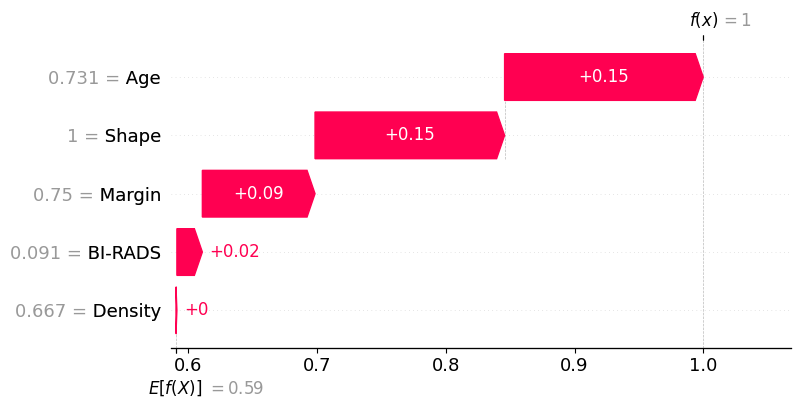

In [ ]:
shap.plots.waterfall(shap_values[0])

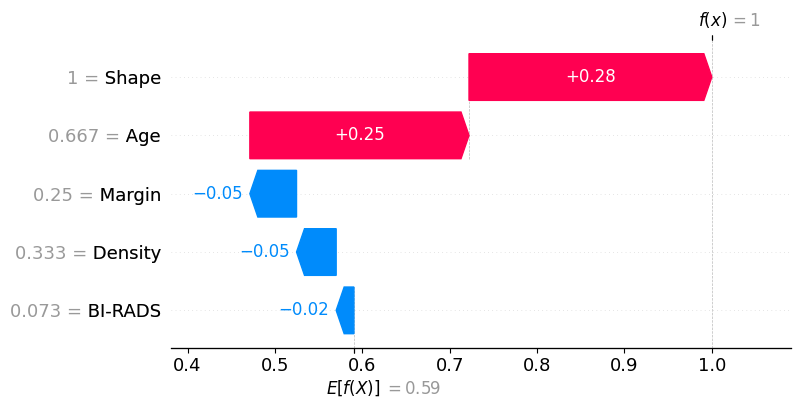

In [ ]:
shap.plots.waterfall(shap_values[1])

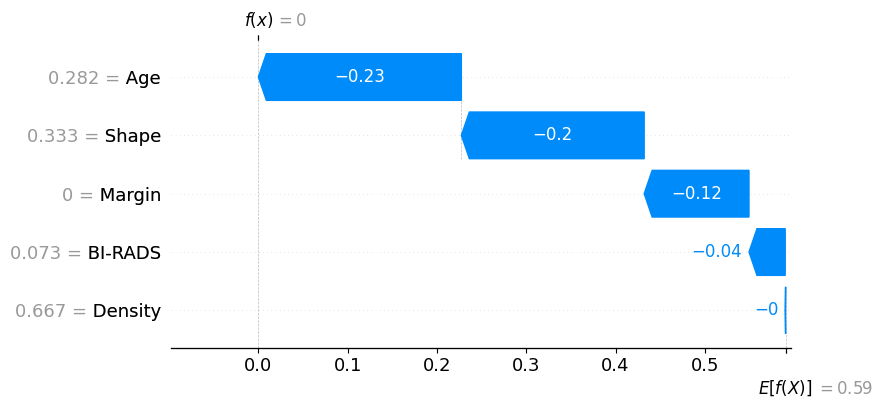

In [ ]:
shap.plots.waterfall(shap_values[9])

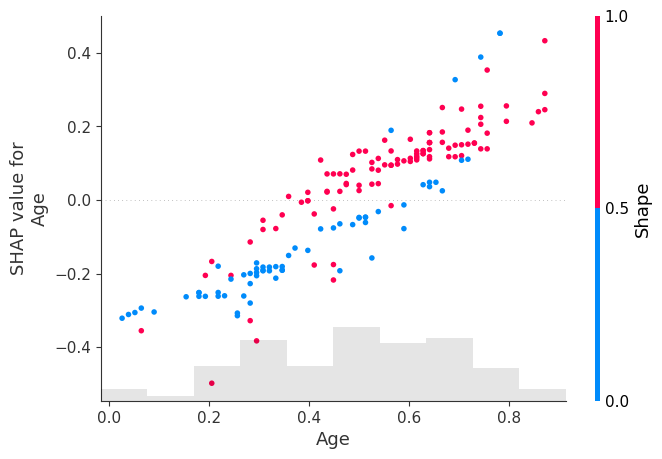

In [ ]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

#### Conclusions

TODO: write

### 2.2. Interpretation of the model

• Based on the parameters obtained, can we say something about the user’s preferences? <br>
• What was the influence of the criteria? Are there any criteria that have no effect, or have a decisive influence? <br>
• Are there any dependencies between the criteria? <br>
• What is the nature of the criterion, gain, cost, non-monotonic? <br>
• Whether there are any preference thresholds? Are there any evaluations on criteria that are indifferent in terms of preferences? <br>
• Interpret the model by at least one (Global Surrogate, Partial Dependence Plot, Permutation Feature Importance ...) <br>

TODO: write